<a href="https://colab.research.google.com/github/jai2shan/TSAI-EVA40-Assignments/blob/master/Session%2011/Assignment%2011%20-%20Model%20Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
os.chdir(r'/content')
# !git clone https://github.com/jai2shan/TSAI-EVA40-Assignments.git
import os
os.chdir(r'/content/TSAI-EVA40-Assignments/Session 11/asgnmt11')

In [0]:
from torchvision import transforms
from DataLoader import cifar_data_loader,View_images
import torch
from torchsummary import summary
from assignment11_model import Net

from LR_Finder_acc import *
from Training_Testing import TrainTest
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from ModelPerformance import *
from gradcam import GradCamDisplay
import PIL
from gradcam import *
import copy

In [3]:
### Data Loading
trainloader,testloader = cifar_data_loader(BatchSize=512)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

net = Net().to(device)
summary(net, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

## Estimating LR Max


Learning rate search finished. See the graph with {finder_name}.plot()


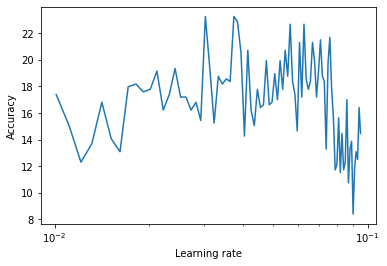

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)

lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, start_lr=1e-5, end_lr=0.1,
                     num_iter=100, step_mode="linear")
lr_finder.plot()

import pandas as pd
lr_ = pd.DataFrame(lr_finder.history)
lr_max = lr_[lr_['accuracy']==lr_finder.best_accuracy]['lr']

## Estimating LR Min

No. of Iterations per epoch : 100(50000/512)    
10 epochs: 1000 iterations

In [0]:
mins = [lr_max.values[0]/i for i in list(range(5,7))]

for i in mins:
  tt = TrainTest()
  test_acc = 0
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=i, momentum=0.9,weight_decay = 0.0005)

  for epoch in range(1):
      print("EPOCH:", epoch)
      tt.train_(net, device, trainloader, optimizer, criterion, epoch,L1 = False)
      acc = tt.test_(net, device, testloader)
  torch.cuda.empty_cache()



  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0



Loss=0.8778223991394043 Batch_id=0 Accuracy=67.58:   0%|          | 0/98 [00:02<?, ?it/s]
Loss=0.8778223991394043 Batch_id=0 Accuracy=67.58:   1%|          | 1/98 [00:02<03:20,  2.06s/it]
Loss=0.8190242052078247 Batch_id=1 Accuracy=68.95:   1%|          | 1/98 [00:02<03:20,  2.06s/it]
Loss=0.8190242052078247 Batch_id=1 Accuracy=68.95:   2%|▏         | 2/98 [00:02<02:27,  1.53s/it]
Loss=0.904582679271698 Batch_id=2 Accuracy=67.77:   2%|▏         | 2/98 [00:02<02:27,  1.53s/it] 
Loss=0.904582679271698 Batch_id=2 Accuracy=67.77:   3%|▎         | 3/98 [00:02<01:50,  1.17s/it]
Loss=0.864097535610199 Batch_id=3 Accuracy=68.21:   3%|▎         | 3/98 [00:02<01:50,  1.17s/it]
Loss=0.864097535610199 Batch_id=3 Accuracy=68.21:   4%|▍         | 4/98 [00:02<01:25,  1.10it/s]
Loss=0.8592584729194641 Batch_id=4 Accuracy=68.63:   4%|▍         | 4/98 [00:03<01:25,  1.10it/s]
Loss=0.8592584729194641 Batch_id=4 Accuracy=68.63:   5%|▌         | 5/98 [00:03<01:16,  1.21it/s]
Loss=0.9218035936355591 Batch_


Test set: Average loss: 0.7407, Accuracy: 7392/10000 (73.92%)

deleted
EPOCH: 0



Loss=0.8227804899215698 Batch_id=0 Accuracy=69.53:   0%|          | 0/98 [00:01<?, ?it/s]
Loss=0.8227804899215698 Batch_id=0 Accuracy=69.53:   1%|          | 1/98 [00:01<03:01,  1.87s/it]
Loss=0.8868977427482605 Batch_id=1 Accuracy=67.97:   1%|          | 1/98 [00:02<03:01,  1.87s/it]
Loss=0.8868977427482605 Batch_id=1 Accuracy=67.97:   2%|▏         | 2/98 [00:02<02:14,  1.40s/it]
Loss=0.7279601097106934 Batch_id=2 Accuracy=70.31:   2%|▏         | 2/98 [00:02<02:14,  1.40s/it]
Loss=0.7279601097106934 Batch_id=2 Accuracy=70.31:   3%|▎         | 3/98 [00:02<01:41,  1.07s/it]
Loss=0.8455334305763245 Batch_id=3 Accuracy=70.85:   3%|▎         | 3/98 [00:02<01:41,  1.07s/it]
Loss=0.8455334305763245 Batch_id=3 Accuracy=70.85:   4%|▍         | 4/98 [00:02<01:19,  1.18it/s]
Loss=0.8913002014160156 Batch_id=4 Accuracy=70.59:   4%|▍         | 4/98 [00:03<01:19,  1.18it/s]
Loss=0.8913002014160156 Batch_id=4 Accuracy=70.59:   5%|▌         | 5/98 [00:03<01:13,  1.27it/s]
Loss=0.8466508388519287 Bat

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

class TrainTest:
    
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_acc = []
        self.test_acc = []
    

    def train_(self,model, device, train_loader, optimizer, criterion, epoch,L1 = False):
          model.train()
          pbar = tqdm(train_loader)
          correct = 0
          processed = 0
          for batch_idx, (data, target) in enumerate(pbar):
            # get samples
            data, target = data.to(device), target.to(device)
        
            # Init
            optimizer.zero_grad()
            # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
            # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
        
            # Predict
            y_pred = model(data)
        
            outputs = model(data)
            loss = criterion(outputs, target)
            if L1 == True:
                l1_crit = nn.L1Loss(size_average=False)
                reg_loss = 0
                for param in model.parameters():
                    reg_loss += l1_crit(param,target=torch.zeros_like(param))

                factor = 0.0005
                loss += factor * reg_loss
            
            self.train_losses.append(loss)
        
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            # Update pbar-tqdm
            
            pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
        
            pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
            self.train_acc.append(100*correct/processed)
            
    def test_(self,model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
    
        test_loss /= len(test_loader.dataset)
        self.test_losses.append(test_loss)
    
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        
        self.test_acc.append(100. * correct / len(test_loader.dataset))
        accT =100. * correct / len(test_loader.dataset)
        return accT

    def __del__(self):
       print("deleted")

In [0]:
iters